# 라이브러리 불러오기 및 하이퍼파라미터 설정


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import os
import numpy as np
import matplotlib.pyplot as plt

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device = {device}")

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

device = cuda


In [3]:
# 하이퍼파라미터 설정
latent_size = 64
hidden_size = 256
image_size = 784 # 28 * 28
num_epochs = 200
batch_size = 100

# MNIST DATASET

In [4]:
# Image Processing
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], # 1 for gray scale 만약, RGB channels라면 mean=(0.5, 0.5, 0.5)
                                         std=[0.5])])  # 1 for gray scale 만약, RGB channels라면 std=(0.5, 0.5, 0.5)

# MNIST 데이터셋
mnist_train = dsets.MNIST(root='data/',
                         train=True, # 트레인 셋
                         transform=transform,
                         download=True)
mnist_test  = dsets.MNIST(root='data/', 
                          train=False,
                          transform=transform,
                          download=True)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


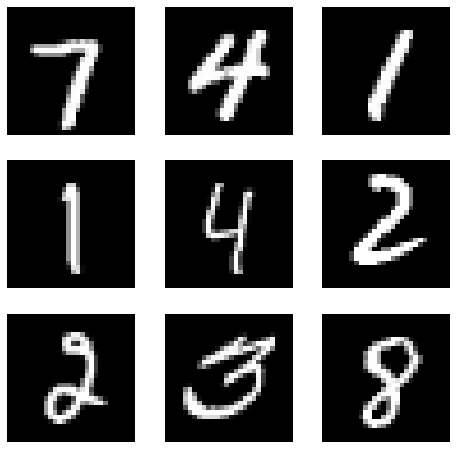

In [5]:
# 랜덤으로 9개만 시각화
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off") # x축, y축 안보이게 설정
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Data Loader

In [6]:
# 데이터 로더
data_loader = torch.utils.data.DataLoader(dataset=mnist_train, # 훈련용 데이터 로딩
                                          batch_size=batch_size,
                                          shuffle=True) # 에폭마다 데이터 섞기

# 생성자 G 와 판별자 D

In [7]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()) # Binary Cross Entropy loss 를 사용할 것이기에 sigmoid 사용!

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

In [39]:
def imshow(img):
    img = (img+1) / 2
    img = img.squeeze() # 차원 중 사이즈 1 을 제거
    np_img = img.numpy() # 이미지 픽셀을 넘파이 배열로 변환
    plt.imshow(np_img,cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach()) # 이미지 그리드 생성, 이미지 출력만을 위해 cpu에 담고 추적 방이
    img = (img+1)/2
    npimg = img.numpy() # 이미지 픽셀을 넘파이 배열로 변환
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

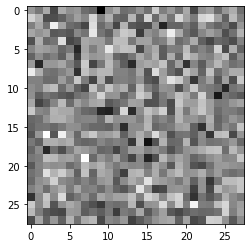

In [45]:
# 생성자 이용해 데이터 만들기
rand = torch.randn(1, 100, device=device)
img_1 = G(rand).view(-1,28,28)

imshow(img_1.squeeze().cpu().detach())

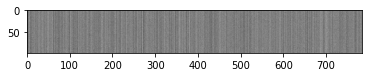

In [46]:
# Batch SIze만큼 노이즈 생성하여 그리드로 출력
rand = torch.randn(batch_size, 100, device=device)
img_1 = G(rand)
imshow_grid(img_1)

In [48]:
# 판별자를 이용해 데이터 판별하기
print(D(G(rand)[0:5]).transpose(0,1))

tensor([[0.4876, 0.4863, 0.4848, 0.4890, 0.4840]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


# 훈련시키기

In [49]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [52]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad(): # 가중치를 0으로 초기화
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [58]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
    
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # real image 저장
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 생성된 이미지 저장
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 생성자, 판별자 각각 모델 저장
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/200], Step [200/600], d_loss: 0.2900, g_loss: 2.8647, D(x): 0.91, D(G(z)): 0.11
Epoch [0/200], Step [400/600], d_loss: 0.2017, g_loss: 2.7347, D(x): 0.95, D(G(z)): 0.11
Epoch [0/200], Step [600/600], d_loss: 0.3059, g_loss: 3.7174, D(x): 0.90, D(G(z)): 0.05
Epoch [1/200], Step [200/600], d_loss: 0.3268, g_loss: 3.0135, D(x): 0.89, D(G(z)): 0.13
Epoch [1/200], Step [400/600], d_loss: 0.3035, g_loss: 4.3137, D(x): 0.93, D(G(z)): 0.17
Epoch [1/200], Step [600/600], d_loss: 0.1228, g_loss: 5.4722, D(x): 0.94, D(G(z)): 0.02
Epoch [2/200], Step [200/600], d_loss: 0.2463, g_loss: 4.2998, D(x): 0.94, D(G(z)): 0.10
Epoch [2/200], Step [400/600], d_loss: 0.0528, g_loss: 4.7057, D(x): 0.99, D(G(z)): 0.04
Epoch [2/200], Step [600/600], d_loss: 0.1515, g_loss: 4.5762, D(x): 0.92, D(G(z)): 0.03
Epoch [3/200], Step [200/600], d_loss: 0.3861, g_loss: 2.7867, D(x): 0.88, D(G(z)): 0.11
Epoch [3/200], Step [400/600], d_loss: 0.3778, g_loss: 4.0542, D(x): 0.89, D(G(z)): 0.05
Epoch [3/200], Step [